# Rate of Change 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from hurst import compute_Hc
from ib_insync import *
import nest_asyncio

In [57]:
nest_asyncio.apply()

# Connect to TWS (or gateway)
ib = IB()

ib.connect('127.0.0.1', 7496, clientId=1111) #7497 - Paper Trading, 7496 - Live trading

<IB connected to 127.0.0.1:7496 clientId=1111>

Error 200, reqId 51: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 52: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 53: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 54: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 55: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 56: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 57: No security definition has been found for the request, contract: Stock(exchange='SMART', currency='CAD')
Error 200, reqId 58: No security definition has been found for the request, contract: Stock(exchange='SMART', currency

### For IBKR Data

In [23]:
#Futures:
#contract = Future('ES', '202506', 'CME')

# Stocks:
contract = Stock('BDT', 'SMART', 'CAD')

# Qualify the contract (ensures IB recognizes it)
ib.qualifyContracts(contract)

# Fetch historical data
historical_data = ib.reqHistoricalData(
    contract,
    endDateTime='',          # Leave empty for the most recent data
    durationStr='10 M',       
    barSizeSetting='1 day',  #
    whatToShow='TRADES',     # Show trade data (other options: MIDPOINT, BID, ASK)
    useRTH=True              # Use RTH only
)

# Convert data to a DataFrame
df = util.df(historical_data)
df.set_index('date', inplace=True)
df.tail()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2025-04-10,20.16,20.34,18.84,19.26,107265.0,19.3820,787
2025-04-11,19.08,19.75,18.95,19.55,94245.0,19.3495,610
2025-04-14,19.99,20.21,19.31,20.09,140337.0,19.7680,659
2025-04-15,20.06,20.51,19.71,20.49,116435.0,20.2435,807
2025-04-16,20.32,20.67,20.32,20.50,6527.0,20.4770,63


### Trading View Data
##### Next Cell just for Tradingview Data:

In [28]:
df1 = pd.read_csv('CL_1.csv')
df2 = pd.read_csv('CL_2.csv')
df3 = pd.read_csv('CL_3.csv')

df = pd.concat([df1, df2, df3]).drop_duplicates()

df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index, unit='s')
df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('US/Eastern')

In [136]:
df['date_column'] = df.index.date
df['time'] = df.index.strftime('%H:%M')
df['return'] = df['close'].pct_change()*100
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

df.head()

,open,high,low,close,volume,average,barCount,date_column,time,return,log_return
date,,,,,,,,,,,
2024-06-20 09:30:00-04:00,88.23,88.31,86.83,87.15,48742.0,87.6515,444,2024-06-20,09:30,NaN,NaN
2024-06-20 09:35:00-04:00,87.20,87.53,87.07,87.53,13602.0,87.3245,116,2024-06-20,09:35,0.436030,0.004351
2024-06-20 09:40:00-04:00,87.52,87.76,87.36,87.75,11904.0,87.5420,101,2024-06-20,09:40,0.251342,0.002510
2024-06-20 09:45:00-04:00,87.66,87.77,87.43,87.71,10032.0,87.5755,93,2024-06-20,09:45,-0.045584,-0.000456
2024-06-20 09:50:00-04:00,87.67,88.15,87.67,88.08,20602.0,87.9265,153,2024-06-20,09:50,0.421845,0.004210


In [177]:
rows_per_day = df.groupby('date_column').size()
print("Rows per day:")
print(rows_per_day.tail(10))

Rows per day:
date_column
2025-04-01    78
2025-04-02    78
2025-04-03    78
2025-04-04    78
2025-04-07    78
2025-04-08    78
2025-04-09    78
2025-04-10    78
2025-04-11    78
2025-04-14    47
dtype: int64


# Past Return

In [179]:
df['past_return'] = (df['close'] - df['close'].shift(390)) / df['close'].shift(390)

# ROC (Rate of Change)

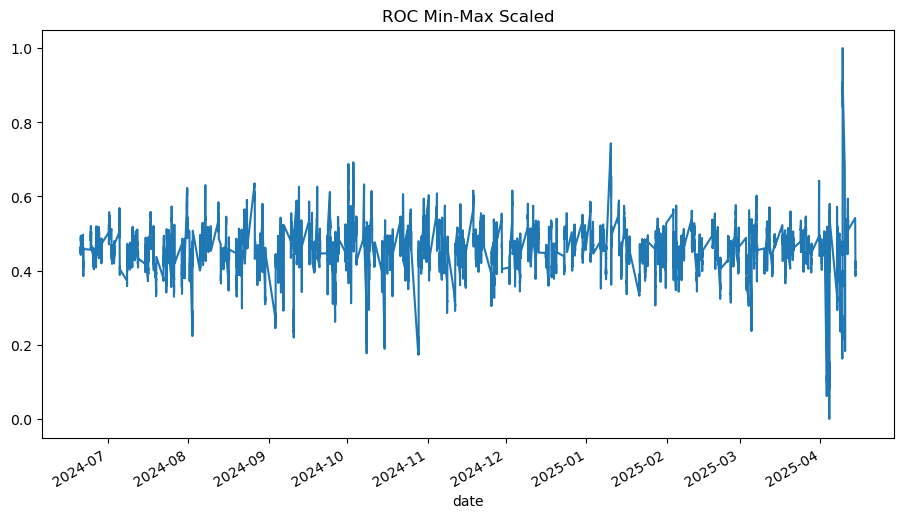

In [187]:
period = 39

df['roc'] = ((df['close'] - df['close'].shift(period)) / df['close'].shift(period)) * 100
# min max scaling
df['roc'] = (df['roc'] - df['roc'].min()) / (df['roc'].max() - df['roc'].min())

# z score of ROC
df['roc_zscore'] = (df['roc'] - df['roc'].rolling(period).mean()) / df['roc'].rolling(period).std()

df['roc'].plot(figsize=(11,6))
plt.title('ROC Min-Max Scaled')
plt.show()

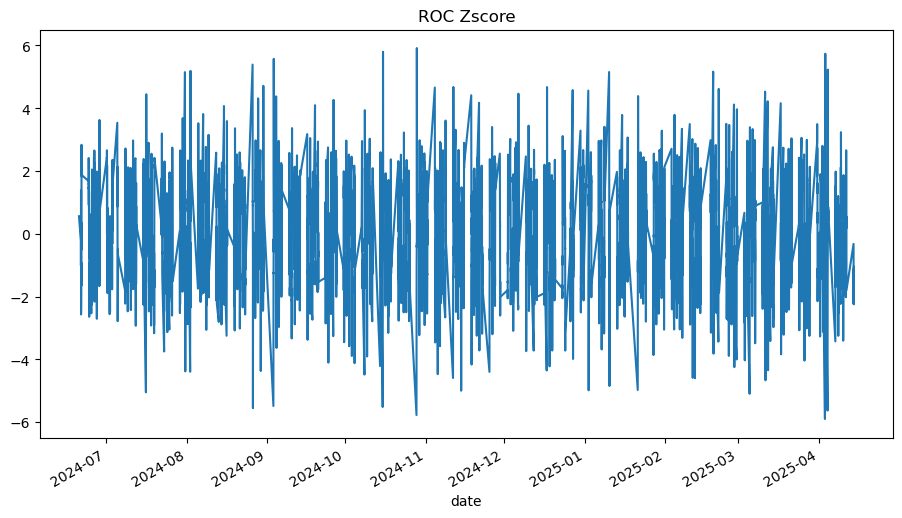

In [183]:
df['roc_zscore'].plot(figsize=(11,6))
plt.title('ROC Zscore')
plt.show()

### Past Returns

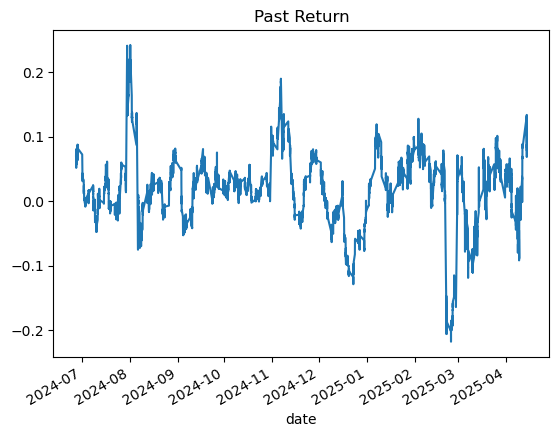

In [53]:
df['past_return'].plot()
plt.title('Past Return')
plt.show()

### Historical Volatility

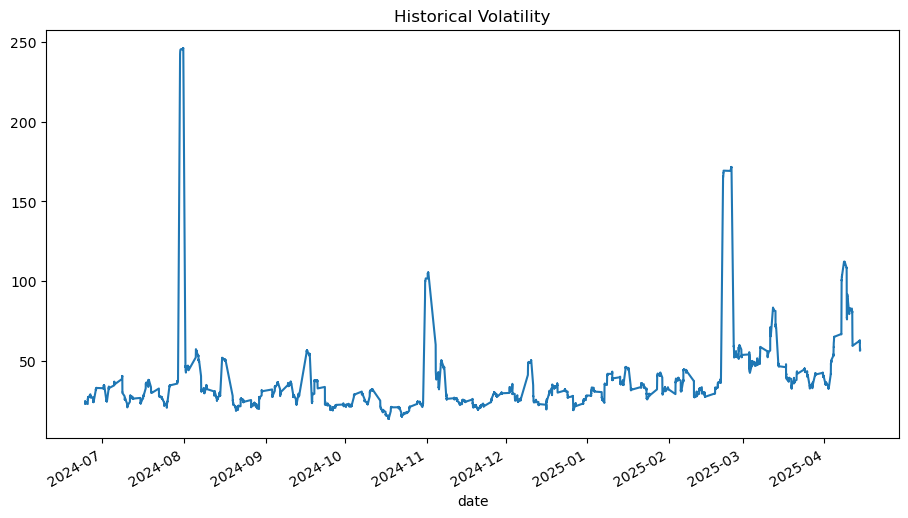

In [55]:
window = 156 #(# candles in day x  desired period)

df['historical_vol'] = (df['return'].rolling(window).std()) * np.sqrt(19656)
#df['historical_vol_zscore'] = (df['historical_vol'] - df['historical_vol'].rolling(window).mean()) / df['historical_vol'].rolling(window).std()

df['historical_vol'].plot(figsize=(11,6))
plt.title("Historical Volatility")
plt.show()

### Hurst Exponent

In [57]:
# Define rolling window size for Hurst
df.dropna(inplace=True)
window_size = 252

# Calculate Hurst exponent for each rolling window
hurst_values = []
for i in range(len(df) - window_size):
    window = df['close'][i:i + window_size]
    H, _, _ = compute_Hc(window, kind='price', simplified=True)
    hurst_values.append(H)

# Add Hurst values to the DataFrame
df['hurst'] = [np.nan] * window_size + hurst_values

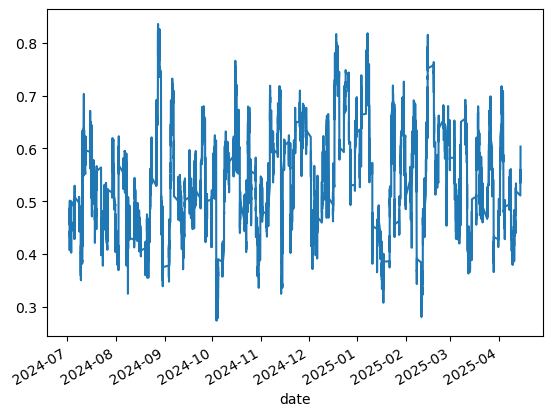

In [59]:
df['hurst'].plot()
plt.show()

### Percent of Down Candles

In [61]:
rolling_period = 156

df['down_day'] = 0
df.loc[df['return'] < 0, 'down_day'] = 1

df['percent_of_days_down'] = ((df['down_day'].rolling(rolling_period).sum())/rolling_period)*100

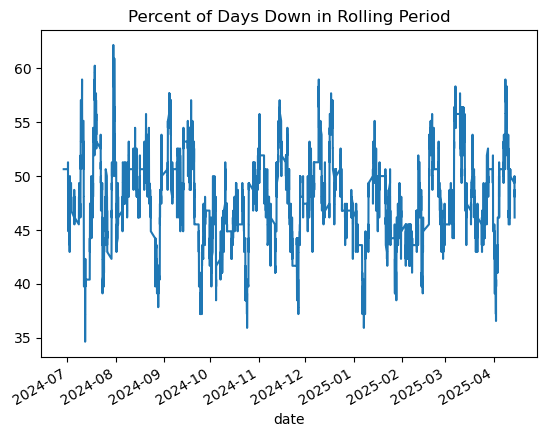

In [63]:
df['percent_of_days_down'].plot()
plt.title('Percent of Days Down in Rolling Period')
plt.show()

# Signal

In [65]:
df[['roc', 'roc_zscore', 'historical_vol', 'hurst', 'percent_of_days_down', 'past_return']].describe()

,roc,roc_zscore,historical_vol,hurst,percent_of_days_down,past_return
count,15449.000000,15449.000000,15449.000000,15197.000000,15294.000000,15449.000000
mean,0.484257,-0.013279,38.599440,0.537970,47.825693,0.018197
std,0.048280,1.368599,29.440526,0.098440,4.311512,0.058796
min,0.000000,-5.872910,13.427425,0.273703,34.615385,-0.218158
25%,0.465578,-1.082607,24.897530,0.466047,44.871795,-0.009429
50%,0.483782,-0.028059,31.236216,0.529431,47.435897,0.022065
75%,0.502747,1.061171,40.866886,0.607710,50.641026,0.049297
max,1.000000,6.010257,246.285618,0.835886,62.179487,0.242267


In [151]:
print('ROC Threshold (5th Percentile):',df['roc'].quantile(0.05))
print('ROC Threshold (2nd Percentile):',df['roc'].quantile(0.02))
print('PastReturn Threshold:',df['past_return'].quantile(0.05))
print('ROC ZScore Threshold:',df['roc_zscore'].quantile(0.01))

ROC Threshold (5th Percentile): 0.42081844255844103
ROC Threshold (2nd Percentile): 0.39669382614225673
PastReturn Threshold: -0.08757093729811094
ROC ZScore Threshold: -2.9438617880952433


In [155]:
# thresholds for signal
roc_threshold = 0.42
past_return_threshold = -0.08
roc_zscore_threshold = -2.88

vol_threshold = 50
hurst_threshold = 0.55
percent_of_days_down_threshold = 90

# Signal Logic
df['buy_signal'] = 0

#df.loc[(df['past_return'] <= past_return_threshold) & (df['roc'] <= roc_threshold), 'buy_signal'] = 1
#df.loc[(df['past_return'] <= past_return_threshold), 'buy_signal'] = 1
#df.loc[(df['roc'] <= roc_threshold), 'buy_signal'] = 1
df.loc[(df['roc'] <= roc_threshold) & (df['historical_vol'] <= vol_threshold), 'buy_signal'] = 1

In [161]:
df = df.head(8000)

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


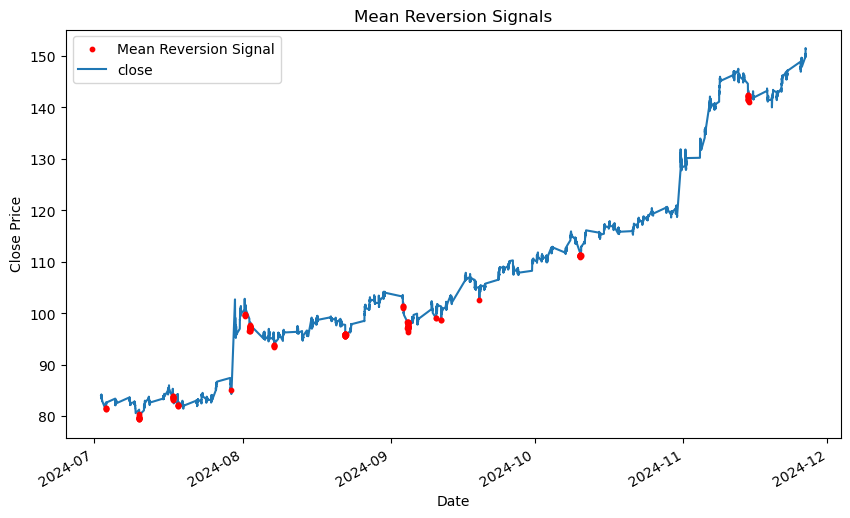

In [163]:
buy_signal = df[df['buy_signal'] == 1]

plt.scatter(buy_signal.index, buy_signal['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Mean Reversion Signals')
plt.legend()
plt.show()

### Rolling Buy Signal Sum

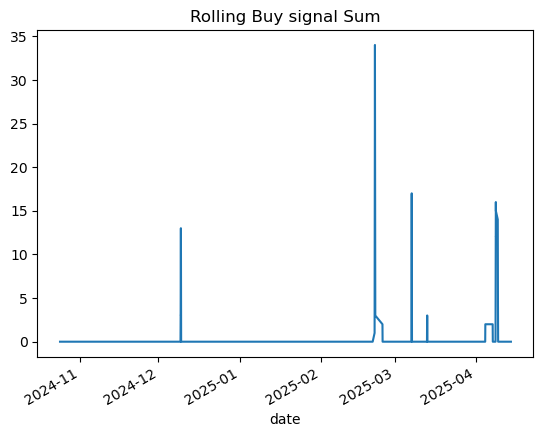

In [173]:
df['buy_signal_rolling_sum'] = df['buy_signal'].rolling(34).sum()

df['buy_signal_rolling_sum'].plot()
plt.title('Rolling Buy signal Sum')
plt.show()

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


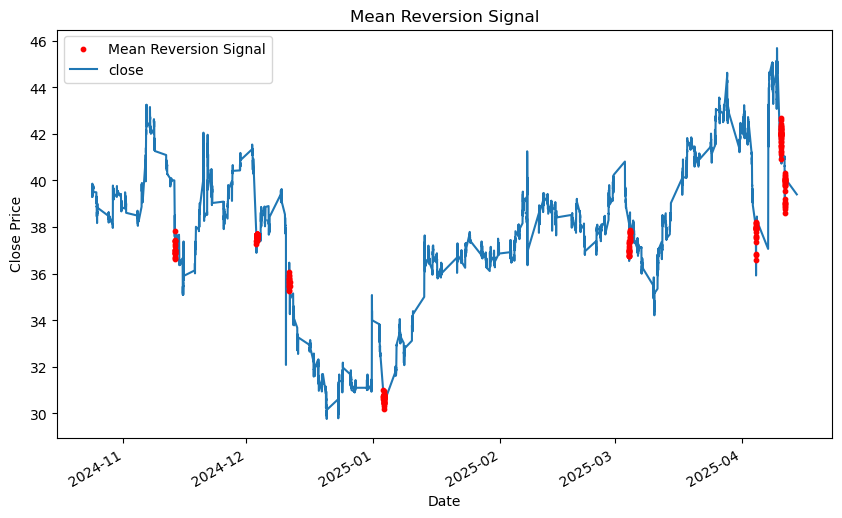

In [75]:
buy_signal_1_threshold = 15

df['buy_signal_1'] = 0 
df.loc[df['buy_signal_rolling_sum'] >= buy_signal_1_threshold, 'buy_signal_1'] = 1

buy_signal_1 = df[df['buy_signal_1'] == 1]

plt.scatter(buy_signal_1.index, buy_signal_1['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Mean Reversion Signal')
plt.legend()
plt.show()

## Supress the following signals so that we don't have signal overlap

In [165]:
# Define the suppression window
window = 280

# Step 1: Identify first signals
df['buy_signal'] = df['buy_signal'] & (df['buy_signal'].shift(1, fill_value=0) == 0)

# Step 2: Suppress signals within the window after each 1
mask = df['buy_signal'].rolling(window=window + 1, min_periods=1).sum().shift(-window) > 0
df['buy_signal'] = df['buy_signal'].where(~mask, df['buy_signal'])

# Convert to integer
df['buy_signal'] = df['buy_signal'].astype(int)

C:\Users\eabiz\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


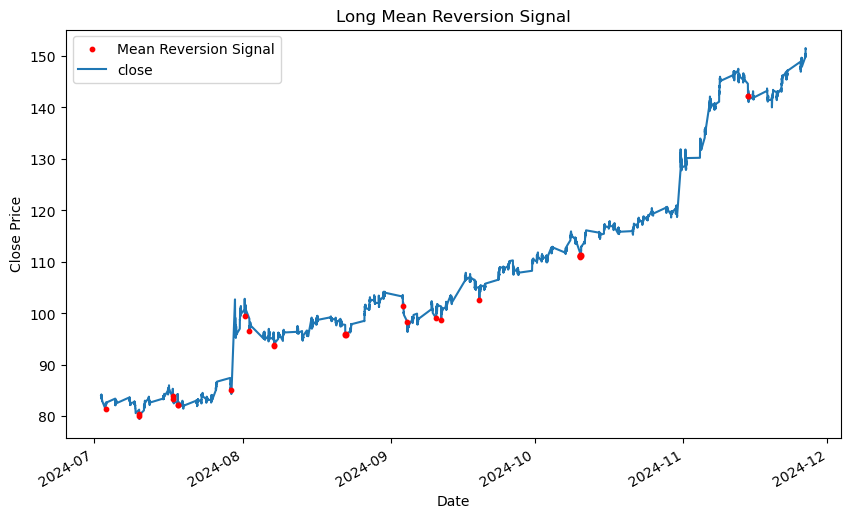

In [167]:
buy_signal = df[df['buy_signal'] == 1]

plt.scatter(buy_signal.index, buy_signal['close'], color='red', s=10, zorder=5, label='Mean Reversion Signal')
df['close'].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Long Mean Reversion Signal')
plt.legend()
plt.show()

# Returns after a Signal

In [169]:
number_days_to_shift_returns = 278
df['return_after_signal'] = (df['close'].shift(-(number_days_to_shift_returns)) - df['close'])/df['close']

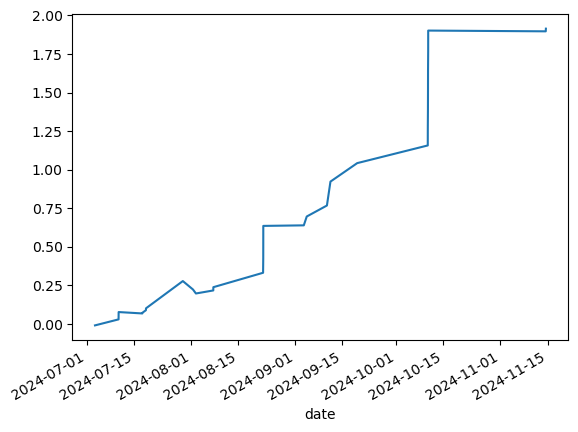

In [171]:
((df.loc[df['buy_signal'] == 1, 'return_after_signal'] + 1).cumprod() - 1).plot()
plt.show()

### Distance From MA

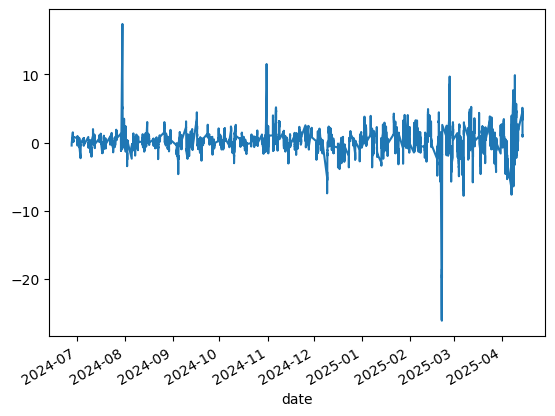

In [121]:
df['distance_from_ma'] = df['close'] - df['close'].rolling(70).mean()
df['distance_from_ma'].plot()
plt.show()

### Rolling Standard Deviation

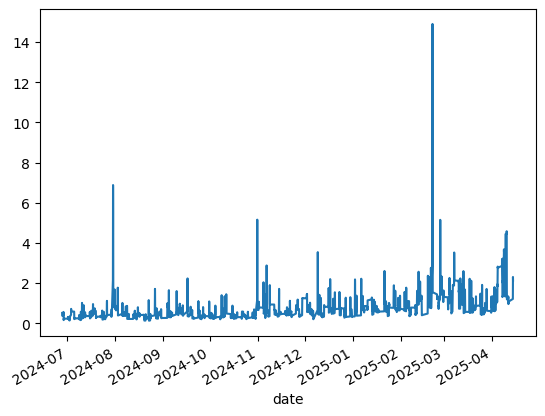

In [123]:
df['std'] = df['close'].rolling(70).std()
df['std'].plot()
plt.show()

# XGBoost

In [127]:
df.dropna(inplace=True)

### Correlation between features

In [249]:
correlation = df['distance_from_ma'].corr(df['roc'])

print('Correlation Coefficient',correlation)

Correlation Coefficient 0.39487921224277694


In [121]:
model = XGBRegressor(
    max_depth=10, #controls depth in the trees 4-10 avoids overfitting
    learning_rate=0.03,
    n_estimators=2500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'  
)

# Fit the model with an evaluation set and early stopping
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Training and test sets for evaluation
    eval_metric='rmse',                               # Metric to monitor
    early_stopping_rounds=50,                         # Stop if no improvement after 50 rounds
    verbose=True                                      # Show progress
)

NameError: name 'X_train' is not defined

In [251]:
X = df[['roc', 'std', 'historical_vol', 'hurst', 'past_return']]
y = df['return_after_signal'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    learning_rate=0.01,
    n_estimators=1500
)


# Fit the model with an evaluation set and early stopping
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
print()
print("Return After Signal Mean:",df['return_after_signal'].mean())

Mean Squared Error: 0.00014646545192719573
Root Mean Squared Error: 0.012102291185027557

Return After Signal Mean: -0.0003413069334973086


# XGBoost Classification

In [253]:
# Example features
X = df[['roc', 'past_return', 'hurst', 'historical_vol', 'std']]

# Example target for classification:
# If df['return_after_signal'] is continuous, convert it to binary labels.
# Here, we'll label observations above the mean as 1 and at or below as 0.
y = (df['return_after_signal'] > df['return_after_signal'].mean()).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use XGBClassifier for classification; use an objective suitable for binary classification.
model = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    random_state=42,
    learning_rate=0.1,
    n_estimators=1500     
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using classification metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9232599643069601

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       873
           1       0.92      0.92      0.92       808

    accuracy                           0.92      1681
   macro avg       0.92      0.92      0.92      1681
weighted avg       0.92      0.92      0.92      1681

Confusion Matrix:
[[808  65]
 [ 64 744]]


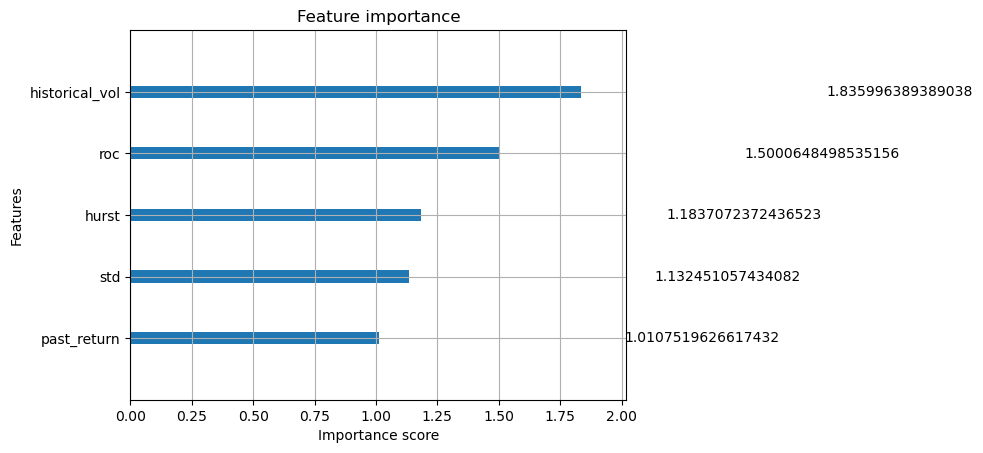

In [257]:
# Plot feature importance
from xgboost import XGBClassifier, plot_importance
plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [795]:
df.tail()

,open,high,low,close,MA,date,time,return,log_return,past_return,roc,roc_zscore,historical_vol,hurst,down_day,percent_of_days_down,buy_signal,return_after_signal,distance_from_ma,std
time,,,,,,,,,,,,,,,,,,,,
2025-03-26 16:00:00-04:00,69.72,69.82,69.72,69.81,67.51780,2025-03-26,16:00,0.143451,0.001433,0.041629,0.667257,1.496051,17.201017,0.467697,0,50.000000,0,-0.106432,0.999286,0.707816
2025-03-27 09:30:00-04:00,69.58,69.62,69.12,69.57,67.53435,2025-03-27,09:30,-0.343790,-0.003444,0.040688,0.664800,1.407825,17.296343,0.469527,1,53.571429,0,-0.148627,0.720429,0.672392
2025-03-27 10:00:00-04:00,69.58,69.78,69.36,69.76,67.55240,2025-03-27,10:00,0.273106,0.002727,0.032717,0.643995,0.487165,15.843639,0.448035,0,50.000000,0,-0.143349,0.878857,0.662296
2025-03-27 10:30:00-04:00,69.77,69.96,69.73,69.91,67.57195,2025-03-27,10:30,0.215023,0.002148,0.029602,0.635868,0.099503,15.525071,0.444880,0,46.428571,0,-0.147761,1.000143,0.662714
2025-03-27 11:00:00-04:00,69.90,69.97,69.81,69.86,67.59090,2025-03-27,11:00,-0.071521,-0.000715,0.024490,0.622526,-0.518359,15.294557,0.444293,1,46.428571,0,-0.147008,0.926286,0.666473


# Linear Regression

In [129]:
# OLS Linear regression
X = df[['roc','roc_zscore','distance_from_ma', 'std', 'historical_vol','hurst', 'percent_of_days_down', 'past_return']]
y = df['return_after_signal']
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     return_after_signal   R-squared (uncentered):                   0.098
Model:                             OLS   Adj. R-squared (uncentered):              0.098
Method:                  Least Squares   F-statistic:                              202.6
Date:                 Mon, 14 Apr 2025   Prob (F-statistic):                        0.00
Time:                         12:46:32   Log-Likelihood:                          23599.
No. Observations:                14919   AIC:                                 -4.718e+04
Df Residuals:                    14911   BIC:                                 -4.712e+04
Df Model:                            8                                                  
Covariance Type:             nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------

# K-Means Clustering

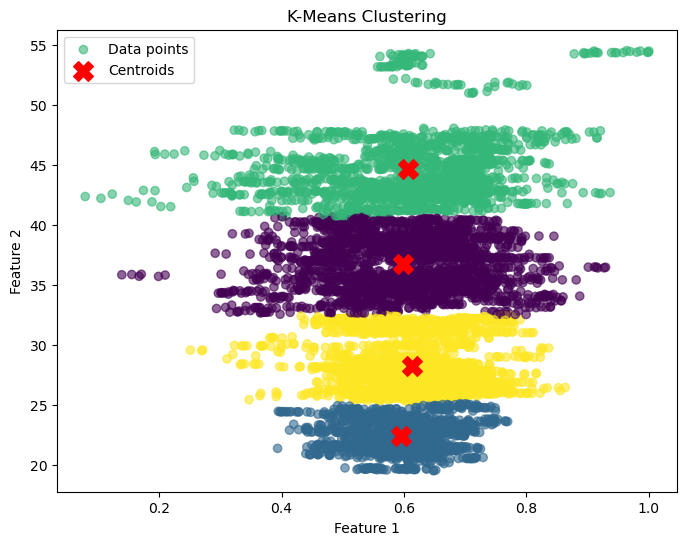

In [357]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Suppose df has two features for visualization: 'feature1' and 'feature2'
X = df[['roc', 'historical_vol']]

# Run K-Means with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Retrieve the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X['roc'], X['historical_vol'], c=labels, cmap='viridis', alpha=0.6, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.legend()
plt.show()


# Screener for Multiple Stocks

In [274]:
# Load ticker list
ticker_list = pd.read_csv('sample_tickers.csv')

# Initialize an empty DataFrame to store returns
returns_df = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list['ticker']:  
    try:
        # Define contract
        contract = Stock(ticker, 'SMART', 'USD')

        # Fetch historical data
        historical_data = ib.reqHistoricalData(
            contract,
            endDateTime='',          # Most recent data
            durationStr='1 Y',       # 1 year of data
            barSizeSetting='1 day',  # Daily candles
            whatToShow='TRADES',     # Trade data
            useRTH=True,             # Regular trading hours
            formatDate=1             # Ensure date is formatted correctly
        )

        # Convert to DataFrame
        df = util.df(historical_data)
        if df is None or df.empty:
            print(f"No data retrieved for {ticker}")
            continue

        # Set date as index
        df.set_index('date', inplace=True)

        # Calculate daily returns
        df['return'] = df['close'].pct_change()

        # Add return column to returns_df (rename to ticker name)
        returns_df[ticker] = df['return']

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Drop rows with all NaN values (optional, depending on your needs)
returns_df = returns_df.dropna()
returns_df.head()

,SPOT,GDDY,ARQT,TPR,MRT,WGS,CLBT,UNM,TATT,QFIN,...,PRI,ETR,TKO,COMP,EAT,PLTR,FI,GOOG,SPY,QQQ
date,,,,,,,,,,,,,,,,,,,,,
2024-04-18,-0.014919,-0.008254,-0.078049,0.000247,0.068966,0.040217,0.000000,0.012560,-0.006261,0.010090,...,-0.007324,0.005426,-0.005502,-0.023952,0.027910,-0.008447,-0.001292,0.003697,-0.002058,-0.005706
2024-04-19,-0.046231,-0.010136,-0.037037,0.002963,0.161290,0.007315,0.008671,0.011223,0.000000,0.000000,...,0.023561,0.028913,-0.002819,-0.006135,-0.001545,-0.031235,0.011640,-0.011050,-0.008728,-0.020689
2024-04-22,-0.013015,0.010739,-0.017582,-0.007632,-0.094444,0.077801,0.000000,0.008567,0.024302,0.014983,...,0.011486,0.006557,-0.000209,0.024691,0.021667,0.024426,0.001211,0.014321,0.009209,0.010057
2024-04-23,0.114127,0.016391,-0.022371,-0.021583,-0.122699,0.154957,0.022923,-0.000193,0.027241,0.012028,...,0.004046,-0.002606,0.001675,0.027108,0.038736,0.031950,0.044288,0.012472,0.011867,0.014923
2024-04-24,-0.072797,0.003485,0.001144,0.014959,0.069930,-0.015000,0.000000,0.003476,-0.011121,0.011885,...,0.015981,-0.006718,0.002404,-0.023460,-0.008542,-0.002311,-0.020207,0.007379,-0.000475,0.003388


# Canadian Stocks

In [276]:
# Load ticker list
ticker_list = pd.read_csv('sample_tickers.csv')

# Initialize an empty DataFrame to store returns
returns_df_cad = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list['ticker_cad']:  
    try:
        # Define contract
        contract = Stock(ticker, 'SMART', 'CAD')

        # Fetch historical data
        historical_data = ib.reqHistoricalData(
            contract,
            endDateTime='',          # Most recent data
            durationStr='1 Y',       # 1 year of data
            barSizeSetting='1 day',  # Daily candles
            whatToShow='TRADES',     # Trade data
            useRTH=True,             # Regular trading hours
            formatDate=1             # Ensure date is formatted correctly
        )

        # Convert to DataFrame
        df = util.df(historical_data)
        if df is None or df.empty:
            print(f"No data retrieved for {ticker}")
            continue

        # Set date as index
        df.set_index('date', inplace=True)

        # Calculate daily returns
        df['return'] = df['close'].pct_change()

        # Add return column to returns_df (rename to ticker name)
        returns_df_cad[ticker] = df['return']

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Drop rows with all NaN values (optional, depending on your needs)
returns_df_cad = returns_df_cad.dropna()
returns_df_cad.head()

No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan
No data retrieved for nan


,CEU,L,CPH,TVK,BDT,DOL,TVE,EMP.A,MRU,X,RBA,CLS
date,,,,,,,,,,,,
2024-04-18,-0.009276,-0.005235,-0.002834,-0.025706,-0.003834,-0.004408,-0.007895,-0.003145,-0.007800,0.012222,-0.009327,-0.018223
2024-04-19,0.033708,0.000270,-0.033542,0.001730,0.027488,-0.001151,0.000000,-0.000315,-0.003716,-0.009330,0.000300,-0.071429
2024-04-22,-0.016304,0.015580,-0.012941,0.004318,0.012841,0.010816,0.005305,0.009467,-0.001865,0.008587,0.000300,0.051758
2024-04-23,0.000000,-0.001660,0.050060,0.008598,0.002641,-0.003596,0.021108,-0.000938,0.004743,0.001099,0.001502,0.014424
2024-04-24,-0.005525,0.012905,-0.034052,0.016908,0.025290,0.017252,0.000000,0.004380,0.005436,-0.009877,0.004698,0.010706


# Concatenate US and CAD dataframes

In [278]:
returns_df = pd.concat([returns_df, returns_df_cad], axis=1)

returns_df.sort_index(ascending=True,inplace=True) # Do this since US has holidays which TSX doesn't
returns_df.fillna(0, inplace=True)
returns_df.tail()

,SPOT,GDDY,ARQT,TPR,MRT,WGS,CLBT,UNM,TATT,QFIN,...,CPH,TVK,BDT,DOL,TVE,EMP.A,MRU,X,RBA,CLS
date,,,,,,,,,,,,,,,,,,,,,
2025-04-10,-0.028187,-0.029405,-0.077557,-0.049941,0.079245,-0.048001,-0.008430,-0.039927,-0.016484,-0.001631,...,-0.056973,-0.043004,-0.059111,0.023100,-0.066138,-0.004337,0.000000,-0.006678,-0.021991,-0.075324
2025-04-11,-0.016925,0.017751,-0.063244,-0.008135,0.017483,0.043295,0.021254,0.019507,0.031657,-0.009801,...,-0.004509,0.030478,0.015057,0.040396,0.014164,0.010673,0.021602,0.026681,0.017732,0.025753
2025-04-14,0.010135,-0.002035,0.027800,0.005994,0.068729,0.045638,-0.008845,0.021924,0.016968,0.062139,...,0.038043,0.022676,0.027621,0.035056,-0.005587,0.034914,0.014873,0.033354,0.005931,0.021195
2025-04-15,0.042282,0.019516,0.019320,0.002509,-0.009646,0.011679,0.015223,0.005721,0.016329,0.003624,...,0.062827,0.032481,0.019910,0.005734,0.016854,-0.000208,0.005682,0.015644,0.005159,0.027971
2025-04-16,-0.004071,-0.002743,-0.015163,-0.003754,-0.006494,-0.015212,-0.008273,-0.000905,-0.000349,-0.031468,...,-0.019704,-0.001508,0.011225,0.005821,0.031768,-0.000417,-0.015563,-0.004094,-0.004619,-0.020104


# Calculate Returns

In [280]:
# Calculate equal-weighted portfolio return
returns_df['portfolio_return'] = returns_df.mean(axis=1)
# Calculate cumulative return
returns_df['cumulative_return'] = (1 + returns_df['portfolio_return']).cumprod() - 1

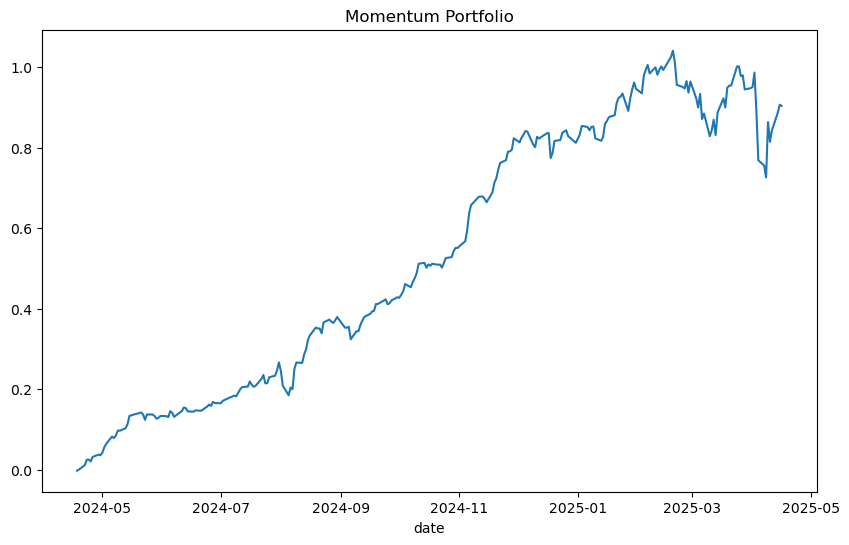

In [282]:
returns_df['cumulative_return'].plot(figsize=(10,6))
plt.title('Momentum Portfolio')
plt.show()

In [284]:
# Convert annual risk-free rate in percent to daily risk-free rate in percent
daily_rf = 4.32 / 252  

# Calculate the daily Sharpe ratio 
daily_mean_return = returns_df['portfolio_return'].mean()*100
daily_std = returns_df['portfolio_return'].std()*100
daily_sharpe_ratio = (daily_mean_return - daily_rf) / daily_std

# Optionally, annualize the Sharpe ratio for daily returns:
annual_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)

print("Daily Sharpe Ratio:", daily_sharpe_ratio)
print("Annualized Sharpe Ratio:", annual_sharpe_ratio)

Daily Sharpe Ratio: 0.1885576618160102
Annualized Sharpe Ratio: 2.993260085765896
